# Homework assignment 3

### Student 1
- Name: Danilo Toapanta
- Student ID: 14077566

### Student 2
- Name: Zsombor Fülöp
- Student ID: 15002861

## 1. Instructions

Fill in your name(s) and student ID(s) in the cell above. If you work alone, you may remove the part about "Student 2".

Then finish this notebook by writing an ASP encoding of a planning problem. Details about the planning problem and more detailed instructions for what to do can be found below.

## 2. The problem

In this homework assignment, you will write an ASP program to solve the
following (toy) planning problem.
This problem is about finding a way to deliver some packages from warehouses
to specified delivery locations, using several (electric) trucks.

The problem works in time steps. At each time step, each truck can perform exactly
one action—move to an adjacent node, wait, (un)load a package, and so on (more details below).
The problem operates on a map that consists of a graph with nodes and edges.
All nodes and edges are single capacity, meaning that only a single truck can be on a node or travel on an edge at each time step.
The task is to find a plan (a sequence of actions, one per truck per time step)
after which the goal state is achieved: all packages are delivered, the trucks are empty (i.e., without packages) and are located on a charging spot.

### The initial state

The initial state of the world consists of:
- a road network in the form of an undirected graph;
- the location (on the network) and initial load (number of available packages) of one or more warehouses;
- the location (on the network) and initial demand (number of packages to be delivered) of one or more delivery locations;
- the location (on the network) of one or more charging points; and
- the initial location, the initial load (how many packages aboard), the maximum load capacity, the initial battery level, and the maximum battery level of one or more trucks.

(These are all given as part of the input.)

### The actions (and their conditions and effects)

At each time step, each truck performs exactly one of the following actions:
- It can **wait**—the truck stays in the current location, the battery level stays the same.
- It can **move** to an adjacent node—the battery level goes down by 1 unit.
- If it is at a warehouse, the warehouse is not empty, and the truck still has capacity, it can **load** one single package from the warehouse into the truck—the battery level stays the same.
- If it is at a delivery location that still needs some packages, and the truck has at least one package, it can **unload** one single package at the delivery location—the battery level stays the same.
- If it is at a charging station, and the battery is not at full capacity, it can **charge**—the battery level increases by 1 unit.

The following additional restrictions have to be taken into account:
- If the battery level of a truck is 0, it cannot move to another node.
- At each location, there can be at most one truck at the same time.
- Trucks cannot pass each other on a piece of road—e.g., trucks at adjacent locations cannot swap places in a single time step.

### The goal

The goal is to achieve a state that has all of the following properties:
- All required deliveries must have been performed.
- Each truck has no packages aboard.
- Each truck is located at a charging station.

### The task

Finish this notebook by encoding this problem into ASP.
Make sure that your encoding works for any given input (that is of the right format).
That is, for each input, your code constructs an answer set program
whose answer sets correspond to the (shortest) sequences
of actions that achieve the goal from the initial state of the world—if the goal state can be reached within a given maximum number of steps.

## 3. Setting up
We begin with setting up and importing some relevant things.

In [ ]:
### DO NOT CHANGE THIS CELL

%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

import clingo
from IPython.display import clear_output

## 4. Input
As input for our planning problem, we get a road network in the form of an undirected graph, specified as:
- a list of nodes
- a list of pairs of nodes, specifying the edges of the graph (these are to be interpreted as undirected)

Additionally, we get:
- a list of dictionaries specifying the factories (with their location on the graph and initial load)
- a list of dictionaries specifying the delivery points (with their location and initial demand)
- a list of dictionaries specifying the charging points (with their location)
- a list of dictionaries specifying the trucks, with:
  * their initial location
  * their initial load
  * their (load) capacity
  * their initial charge level
  * their maximum charge capacity

(See the example input below for the exact format of these dictionaries.)

Moreover, as part of the input, we get a maximum number of time steps, within which the goal should be reached.

### Example input

In [ ]:
### YOU MAY CHANGE THIS CELL TO TEST YOUR SOLUTION ON DIFFERENT INPUTS

nodes = list(range(1, 6+1))
edges = [
    (1,2),
    (2,3),
    (3,4),
    (4,5),
    (2,6),
    (3,6),
]
factories = [
    {
        'location': 1,
        'load': 10,
    },
]
delivery_points = [
    {
        'location': 4,
        'demand': 2,
    },
    {
        'location': 5,
        'demand': 2,
    },
]
charging_points = [
    {
        'location': 2,
    },
    {
        'location': 6,
    },
]
trucks = [
    {
        'location': 1,
        'load': 0,
        'capacity': 1,
        'charge level': 2,
        'charge capacity': 10,
    },
    {
        'location': 2,
        'load': 0,
        'capacity': 1,
        'charge level': 2,
        'charge capacity': 10,
    },
]

num_time_steps = 40

### Checking input assumptions

We will only consider inputs that have the following properties:
- no node is both a warehouse and a delivery location;
- no node is both a warehouse and a charging location; and
- no node is both a delivery and a charging location.

This means that your solution only needs to work for inputs that satisfy these assumptions.

The following code will check these assumptions, and throw an exception if they are not satisfied.

In [ ]:
### DO NOT CHANGE THIS CELL

warehouse_locations = [
    warehouse_info['location']
    for warehouse_info in factories
]
truck_locations = [
    truck_info['location']
    for truck_info in trucks
]
delivery_locations = [
    dp_info['location']
    for dp_info in delivery_points
]
charging_locations = [
    cp_info['location']
    for cp_info in charging_points
]

class InvalidInputError(Exception):
    pass

intersection = [location for location in warehouse_locations if location in delivery_locations]
if len(intersection) > 0:
    raise InvalidInputError(f'node {intersection[0]} is both a warehouse and a delivery location')

intersection = [location for location in warehouse_locations if location in charging_locations]
if len(intersection) > 0:
    raise InvalidInputError(f'node {intersection[0]} is both a warehouse and a charging location')

intersection = [location for location in delivery_locations if location in charging_locations]
if len(intersection) > 0:
    raise InvalidInputError(f'node {intersection[0]} is both a delivery and a charging location')

In [ ]:
asp_program = """
#const n=6. 
#const t=40.

% Generate time(1), time(2), ..., time(Max), for some Max <= t.
possible_time(1..t).
{ time(T) : possible_time(T) }.
:- not time(1).
:- possible_time(T), possible_time(T+1), not time(T), time(T+1).

% Store the last time step
max_time(MaxTime) :- MaxTime = #max { T : time(T) }.

% nodes(N).
nodes(1..n).

% edges(N1,N2)
edges(1,2).
edges(2,3).
edges(3,4).
edges(4,5).
edges(2,6).
edges(3,6).
edges(Y,X):- edges(X,Y).

% factory(T,N,Factory_pac_num)
factory(1,1,10).

% delivery_load_state(N,T,Load)
delivery_load_state(4,1,0).
delivery_load_state(5,1,0).

% delivery_demand(N,D)
delivery_demand(4,2).
delivery_demand(5,2).

% charging_points(N)
charging_point(2).
charging_point(6).

% truck_at_t(ID,T,N)
truck_at_t(1,1,1). 
truck_at_t(2,1,2).

% truck_load_state(ID,T,L)
truck_load_state(1,1,0).
truck_load_state(2,1,0).

% truck_bat_cap(ID,Load_cap)
truck_load_cap(1,1).
truck_load_cap(2,1).

% truck_bat_state(ID,T,B)
truck_bat_state(1,1,2).
truck_bat_state(2,1,2).

% truck_bat_cap(ID,Battery_cap)
truck_bat_cap(1,10).
truck_bat_cap(2,10).

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% DO-s %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

% We perform exactly one action at each time step (except the last time step)
1 { do(T,ID,A) : action(ID,A,T) } 1 :- time(T), T < M, max_time(M), truck_at_t(ID,T,_).

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% ACTIONS %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

% Action - Moving of trucks
action(ID, move_to(N1,N2), T) :- edges(N1,N2),
                                 truck_at_t(ID,T,N1),
                                 truck_bat_state(ID,T,Battery),
                                 Battery > 0, 
                                 time(T).

% Action - Waiting of trucks
action(ID, wait, T) :- truck_at_t(ID,T,_),
                       time(T).

% Action - Charging of trucks
action(ID, charge, T) :- truck_at_t(ID,T,N),
                         truck_bat_state(ID,T,Battery),
                         truck_bat_cap(ID,Battery_cap),
                         charging_point(N),
                         Battery < Battery_cap,
                         time(T).

% Action - load of trucks
action(ID, load, T) :- truck_at_t(ID,T,N),
                       truck_load_state(ID,T,Load),
                       truck_load_cap(ID,Load_cap),
                       Load < Load_cap,
                       factory(T, N, Factory_pac_num),
                       Factory_pac_num > 0,
                       time(T).
                        
% Action - delivery of trucks
action(ID, unload(N), T) :- truck_at_t(ID,T,N),
                            truck_load_state(ID,T,Load),
                            Load > 0,
                            delivery_load_state(N,T,Pac_load),
                            delivery_demand(N,Pac_demand),
                            Pac_load < Pac_demand,
                            time(T).

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% UPDATES %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

% When we perform: 'Move' action
% update truck position and increase time step for battery and load state 
truck_at_t(ID,T2,N2):- truck_at_t(ID,T1,N1),                                 
                       do(T1,ID,move_to(N1,N2)), T2 = T1 + 1.


truck_bat_state(ID,T2,Battery_old -1):- truck_bat_state(ID,T1,Battery_old),
                                        do(T1,ID,move_to(N1,N2)), T2 = T1 + 1.

truck_load_state(ID,T2,Load):- truck_load_state(ID,T1,Load),
                               do(T1,ID,move_to(N1,N2)), T2 = T1 + 1.
                                    
% When we perform: 'Wait' action
% update truck position and increase time step for battery and load stat 
truck_at_t(ID,T2,N):- truck_at_t(ID,T1,N),
                      do(T1,ID,wait), T2 = T1 + 1.

truck_bat_state(ID,T2,Battery):- truck_bat_state(ID,T1,Battery),
                                 do(T1,ID,wait), T2 = T1 + 1.

truck_load_state(ID,T2,Load):- truck_load_state(ID,T1,Load),
                               do(T1,ID,wait), T2 = T1 + 1.

% When we perform: 'Charge' action
% update truck truck position and increase time step for battery and load stat
truck_at_t(ID,T2,N):- truck_at_t(ID,T1,N),
                      do(T1,ID,charge), T2 = T1 + 1.

truck_bat_state(ID,T2,Battery_old + 1):- truck_bat_state(ID,T1,Battery_old),
                                         do(T1,ID,charge), T2 = T1 + 1.

truck_load_state(ID,T2,Load):- truck_load_state(ID,T1,Load),
                               do(T1,ID,charge), T2 = T1 + 1.

% When we perform: 'Load' action
% update of truck truck position and increase time step for battery and load stat
truck_at_t(ID,T2,N):- truck_at_t(ID,T1,N),
                      do(T1,ID,load), T2 = T1 + 1.

truck_bat_state(ID,T2,Battery_old):- truck_bat_state(ID,T1,Battery_old),
                                     do(T1,ID,load), T2 = T1 + 1.

truck_load_state(ID,T2,Load_new) :- truck_load_state(ID,T1,Load_old),
                                    do(T1,ID,load), T2 = T1 + 1,
                                    Load_new = Load_old + 1.

% When we perform: 'Unload' action (when delivering)
% update of truck position and increase time step for battery and load stat
truck_at_t(ID,T2,N):- truck_at_t(ID,T1,N),
                      do(T1,ID,unload(N)), T2 = T1 + 1.

truck_bat_state(ID,T2,Battery_old):- truck_bat_state(ID,T1,Battery_old),
                                     do(T1,ID,unload(N)), T2 = T1 + 1.

truck_load_state(ID,T2,Load_new) :- truck_load_state(ID,T1,Load_old),
                                    do(T1,ID,unload(N)), T2 = T1 + 1,
                                    Load_new = Load_old - 1.

% update of factory load when truck loaded                                  
factory(T2, N, Factory_pac_num_new) :- do(T1,_,load), T2 = T1 + 1,
                                       Factory_pac_num_new = Factory_pac_num_old -1,
                                       Factory_pac_num_old > -1, 
                                       factory(T1, N, Factory_pac_num_old).

% create factory with next time step (unchanged package number) when action other than load happens
factory(T2, N, Factory_pac_num) :- do(T1,_,_), not do(T1,_,load), T2 = T1 + 1,
                                   factory(T1, N, Factory_pac_num).

% update of delivery point's package load when delivering
delivery_load_state(N, T2, Pac_load_new) :- do(T1,_,unload(N)), T2 = T1 + 1,
                                            Pac_load_new = Pac_load_old +1,
                                            delivery_load_state(N, T1, Pac_load_old).

% create delivery points with next time step (unchanged package load) when action other than unload happens
delivery_load_state(N, T2, Pac_load) :- do(T1,_,_), not do(T1,_,unload(N)), T2 = T1 + 1,
                                        delivery_load_state(N, T1, Pac_load).

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% CONSTRAINTS %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

% Restricts that the two trucks cannot be on the same node
:- truck_at_t(ID1,T,N), truck_at_t(ID2,T,N), ID1 != ID2.

% Restrict that the two trucks cannot use the same edge at the same time when moving
:- do(T,ID1,move_to(N1,N2)), do(T,ID2,move_to(N2,N1)), ID1 != ID2.

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% GOAL %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

goal_reached(T) :- time(T), 
                    truck_at_t(1,T,N1), charging_point(N1), truck_load_state(1,T,0),
                    truck_at_t(2,T,N2), charging_point(N2), truck_load_state(2,T,0),
                    delivery_load_state(4,T,2),
                    delivery_load_state(5,T,2).

% We require that we reach the goal at the end
:- max_time(M), not goal_reached(M).

% Once we reached the goal, stop the clock!
:- max_time(M), goal_reached(T), time(T), T < M.

% Find the shortest sequence
#minimize { 1,T : time(T) }.

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% For notebook %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
truck_at(ID,N) :- truck_at_t(ID,T,N).

#show truck_at/2.
#show do/3.
"""

## 6. Finding and outputting solutions

The following cell contains some code that will be used to find (optimal) answer sets for your ASP program, to translate this to a solution for the planning problem, and to display this solution in a human-readable format.

You don't need to finish or change this cell in your solution.

In [ ]:
### DO NOT CHANGE THIS CELL

# Some machinery to (dynamically) print things in the notebook
log_str = ""
def reset_log():
    global log_str
    log_str = ""
def log(msg):
    global log_str
    print(msg, flush=True)
    log_str += f"{msg}\n"
def print_log():
    global log_str
    print(log_str, end='', flush=True)
    
def display_solution(model):
    """
    Displays a solution specified by the answer set
    in a human-readable format.
    
    Assumes that the answer set program uses do/3
    to specify actions, and uses truck_at/2 to
    specify the initial locations of the trucks.
    """
    actions = {}
    truck_locations = {}
    for atom in model.symbols(atoms=True):
        if atom.name == "do":
            time = atom.arguments[0].number
            truck = str(atom.arguments[1])
            action = str(atom.arguments[2])
            if time not in actions:
                actions[time] = {}
            actions[time][truck] = action
        elif atom.name == "truck_at":
            truck_locations[str(atom.arguments[0])] = str(atom.arguments[1])
    solution_str = "\n"
    solution_str += " "*5 + "".join([
        f"{truck:<5} @ {truck_locations[truck]:<10}"
        for truck in sorted(truck_locations)
    ]) + "\n"
    solution_str += "-"*(5+18*len(truck_locations)) + "\n"
    for time in sorted(actions):
        time_str = f"{time}:"
        solution_str += f"{time_str:<4} " + "".join([
            f"{actions[time][truck]:<18}"
            for truck in sorted(truck_locations)
        ]) + "\n"
    return solution_str

def find_and_output_solution(
    asp_program,
    timeout=10,
    num_threads=1,
):
    """
    Calls the ASP solver to find answer sets,
    and translates these to solutions,
    which are printed in human-readable format.
    """

    reset_log()
    log("..Grounding..")
    
    control = clingo.Control([f"--parallel-mode={num_threads}"])
    control.add("base", [], asp_program)
    control.ground([("base", [])])

    control.configuration.solve.models = 1
    control.configuration.solve.opt_mode = "optN"
    
    def interpret_model(model):
        clear_output(wait=True)
        print_log()
        print(display_solution(model))

    if timeout > 0:
        log(f"..Solving with timeout {timeout}s..")
        with control.solve(
            async_=True,
            on_model=lambda model: interpret_model(model),
        ) as handle:
            finished = handle.wait(timeout)
            if not finished:
                log("..Stopped after timeout..")
            else:
                log("..Stopped..")
                time = control.statistics['summary']['times']['total']
                log(f"..Total solving time: {time:.2f} seconds..")
    else:
        log("..Solving..")
        control.solve(
            on_model=lambda model: interpret_model(model),
        )
        log("..Stopped..")
        time = control.statistics['summary']['times']['total']
        log(f"..Total solving time: {time:.2f} seconds..")

## 7. For your convenience: visualizing (part of) the input

For your (and our) convenience, let's visualize the input to the problem. The road network will be displayed as a graph. Nodes with a warehouse are blue. Nodes with a delivery location are green. Nodes with a charging point are purple. All other nodes are red. Nodes where there is a truck initially are labelled with "T".

Note that this doesn't display all the information about the input. For example, the truck (maximum) battery level and (maximum) load is not displayed, and neither is the load/demand of the warehouses and delivery locations.

In [ ]:
### NO NEED TO CHANGE THIS CELL
### (UNLESS THE IMAGE DOESN'T SHOW WELL FOR SOME INPUT YOU ARE USING)

plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.figsize"] = (8, 6)
graph = nx.Graph()

ax = plt.gca()
ax.margins(0.08)

options = {
    "edgecolors": "tab:gray",
    "node_size": 2000,
    "font_color": "white",
    "font_size": 14,
}
graph.add_nodes_from(nodes)
graph.add_edges_from(edges)
layout = nx.spring_layout(graph, seed=42)

labels = {
    node:
    (f"{node} T" if node in truck_locations else f"{node}")
    for node in nodes
}

def node_color(node):
    if node in warehouse_locations:
        return "tab:blue"
    elif node in delivery_locations:
        return "tab:green"
    elif node in charging_locations:
        return "tab:purple"
    else:
        return "tab:red"
colors = [
    node_color(node)
    for node in nodes
]

nx.draw(
    graph,
    layout,
    ax=ax,
    node_color=colors,
    labels=labels,
    with_labels=True,
    **options
)

plt.show()

## 8. Finding and representing solutions

Finally, let's call the solver and display the solution that it might find.

Note that it will display a solution when it finds one, even if it then keeps searching for a better solution. Subsequent better (shorter) solutions will then be displayed, always displaying only the current best solution. Finally, after the solving stopped (possibly due to a time out), it will display "..Stopped.." below the best found solution.

In [56]:
### NO NEED TO CHANGE THIS CELL
### (UNLESS YOU WANT TO SET A SOLVING TIMEOUT
###  OR USE A DIFFERENT NUMBER OF PARALLEL THREADS)

find_and_output_solution(
    asp_program,
    timeout=0,
    num_threads=16,
)

..Grounding..
..Solving..

     1     @ 5         2     @ 4         
-----------------------------------------
1:   load              charge            
2:   move_to(1,2)      move_to(2,6)      
3:   charge            charge            
4:   charge            charge            
5:   charge            charge            
6:   charge            charge            
7:   charge            charge            
8:   charge            charge            
9:   charge            charge            
10:  charge            wait              
11:  move_to(2,3)      move_to(6,2)      
12:  move_to(3,4)      charge            
13:  move_to(4,5)      charge            
14:  unload(5)         move_to(2,1)      
15:  move_to(5,4)      load              
16:  move_to(4,3)      move_to(1,2)      
17:  move_to(3,2)      move_to(2,6)      
18:  charge            charge            
19:  charge            charge            
20:  charge            charge            
21:  charge            move_to(6,3)      
22:  mo

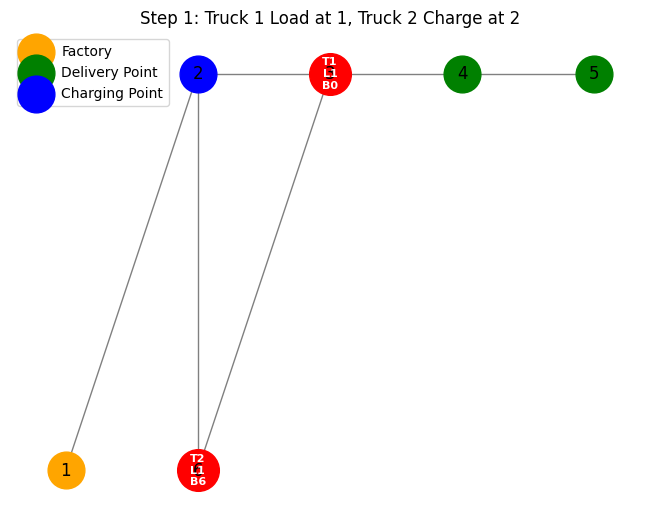

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Define the graph structure and scenario details as provided
nodes = list(range(1, 7))
edges = [(1, 2), (2, 3), (3, 4), (4, 5), (2, 6), (3, 6)]
factories = [{'location': 1, 'load': 10}]
delivery_points = [{'location': 4, 'demand': 2}, {'location': 5, 'demand': 2}]
charging_points = {2, 6}
trucks = [
    {'location': 1, 'load': 0, 'capacity': 1, 'battery': 2, 'battery_capacity': 10},
    {'location': 2, 'load': 0, 'capacity': 1, 'battery': 2, 'battery_capacity': 10},
]

# Define the plan for the two trucks
plan = [
    ("load", 1, 1), ("charge", 2, 2),
    ("move_to", 1, 2), ("move_to", 2, 6),
    ("charge", 1, 2), ("charge", 2, 6),
    ("charge", 1, 2), ("charge", 2, 6),
    ("charge", 1, 2), ("charge", 2, 6),
    ("charge", 1, 2), ("charge", 2, 6),
    ("charge", 1, 2), ("charge", 2, 6),
    ("charge", 1, 2), ("wait", 2, 6),
    ("move_to", 1, 3), ("move_to", 2, 2),
    ("move_to", 1, 4), ("charge", 2, 2),
    ("move_to", 1, 5), ("charge", 2, 2),
    ("unload", 1, 5), ("move_to", 2, 1),
    ("move_to", 1, 4), ("load", 2, 1),
    ("move_to", 1, 3), ("move_to", 2, 2),
    ("move_to", 1, 2), ("move_to", 2, 6),
    ("charge", 1, 2), ("charge", 2, 6),
    ("charge", 1, 2), ("charge", 2, 6),
    ("charge", 1, 2), ("move_to", 2, 3),
    ("move_to", 1, 1), ("move_to", 2, 4),
    ("load", 1, 1), ("unload", 2, 4),
    ("move_to", 1, 2), ("move_to", 2, 3),
    ("move_to", 1, 6), ("move_to", 2, 2),
    ("charge", 1, 6), ("move_to", 2, 1),
    ("charge", 1, 6), ("load", 2, 1),
    ("move_to", 1, 3), ("move_to", 2, 2),
    ("move_to", 1, 4), ("move_to", 2, 3),
    ("move_to", 1, 5), ("move_to", 2, 4),
    ("unload", 1, 5), ("unload", 2, 4),
    ("move_to", 1, 4), ("move_to", 2, 3),
    ("move_to", 1, 3), ("move_to", 2, 2),
    ("move_to", 1, 6), ("charge", 2, 2)
]

# Create a graph
G = nx.Graph()
G.add_edges_from(edges)

# Define positions of nodes for visualization
pos = {
    1: (0, 0),
    2: (1, 1),
    3: (2, 1),
    4: (3, 1),
    5: (4, 1),
    6: (1, 0)
}

# Initial state
truck_positions = {1: 1, 2: 2}
truck_loads = {1: 0, 2: 0}
truck_batteries = {1: 2, 2: 2}

# Function to update the graph for animation
def update(num):
    plt.clf()
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray')

    # Draw nodes with special roles
    nx.draw_networkx_nodes(G, pos, nodelist=[f['location'] for f in factories], node_color='orange', node_size=700, label='Factory')
    nx.draw_networkx_nodes(G, pos, nodelist=[d['location'] for d in delivery_points], node_color='green', node_size=700, label='Delivery Point')
    nx.draw_networkx_nodes(G, pos, nodelist=list(charging_points), node_color='blue', node_size=700, label='Charging Point')

    # Process the plan up to the current step
    for step in range(num + 1):
        action1, truck1, loc1 = plan[step]
        action2, truck2, loc2 = plan[step + 1]
        
        if action1 == "move_to" and truck_batteries[truck1] > 0 and can_move(truck1, loc1):
            truck_positions[truck1] = loc1
            truck_batteries[truck1] -= 1
        elif action1 == "load" and truck_positions[truck1] == factories[0]['location']:
            if truck_loads[truck1] < trucks[truck1 - 1]['capacity'] and factories[0]['load'] > 0:
                truck_loads[truck1] += 1
                factories[0]['load'] -= 1
        elif action1 == "unload" and truck_positions[truck1] in [dp['location'] for dp in delivery_points]:
            if truck_loads[truck1] > 0:
                truck_loads[truck1] -= 1
                for dp in delivery_points:
                    if dp['location'] == truck_positions[truck1] and dp['demand'] > 0:
                        dp['demand'] -= 1
                        break
        elif action1 == "charge" and truck_positions[truck1] in charging_points:
            if truck_batteries[truck1] < trucks[truck1 - 1]['battery_capacity']:
                truck_batteries[truck1] += 1
                
        if action2 == "move_to" and truck_batteries[truck2] > 0 and can_move(truck2, loc2):
            truck_positions[truck2] = loc2
            truck_batteries[truck2] -= 1
        elif action2 == "load" and truck_positions[truck2] == factories[0]['location']:
            if truck_loads[truck2] < trucks[truck2 - 1]['capacity'] and factories[0]['load'] > 0:
                truck_loads[truck2] += 1
                factories[0]['load'] -= 1
        elif action2 == "unload" and truck_positions[truck2] in [dp['location'] for dp in delivery_points]:
            if truck_loads[truck2] > 0:
                truck_loads[truck2] -= 1
                for dp in delivery_points:
                    if dp['location'] == truck_positions[truck2] and dp['demand'] > 0:
                        dp['demand'] -= 1
                        break
        elif action2 == "charge" and truck_positions[truck2] in charging_points:
            if truck_batteries[truck2] < trucks[truck2 - 1]['battery_capacity']:
                truck_batteries[truck2] += 1

    # Draw trucks
    for truck, position in truck_positions.items():
        nx.draw_networkx_nodes(G, pos, nodelist=[position], node_color='red', node_size=900)
        nx.draw_networkx_labels(G, pos, labels={position: f'T{truck}\nL{truck_loads[truck]}\nB{truck_batteries[truck]}'}, font_color='white', font_size=8, font_weight='bold')

    plt.legend(loc='upper left')
    plt.title(f"Step {num//2 + 1}: Truck 1 {action1.capitalize()} at {loc1}, Truck 2 {action2.capitalize()} at {loc2}")

# Create the animation
fig = plt.figure()
ani = animation.FuncAnimation(fig, update, frames=len(plan)//2, interval=1000, repeat=False)

# Save the animation as a GIF file
gif_path = 'truck_delivery_animation.gif'
ani.save(gif_path, writer='imagemagick')